### dset check 
(note: the dataset is introduced and prepared in glacier-mapping repo:    
https://github.com/Hydrological-Observation-Group/glacier-mapping.git)
1. check pair-wise image and truth 
2. check the distribution of the dset. 

In [ ]:
import numpy as np
from glob import glob
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
from rasterio.crs import CRS
from notebooks import config 
import matplotlib.pyplot as plt
from utils.imgShow import imsShow
import cartopy.feature as cfeature
from utils.transform_xy import coor2coor



In [2]:
names_satellite = [path_truth.split('/')[-1][0:2] 
                          for path_truth in config.paths_truth] 
print('Number of scenes:', len(config.paths_scene)) 
print('Satellite:', names_satellite[0])  


Number of scenes: 65
Satellite: l5


#### 1. Check the pair-wise sence and truth images


data/dset/scene/l8_scene_05.tif


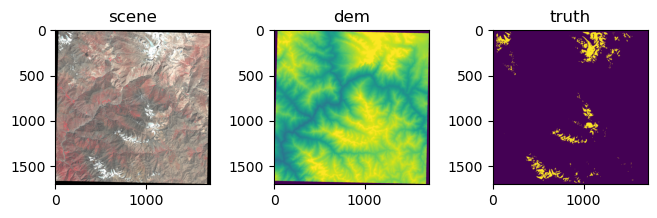

data/dset/scene/l8_scene_06.tif


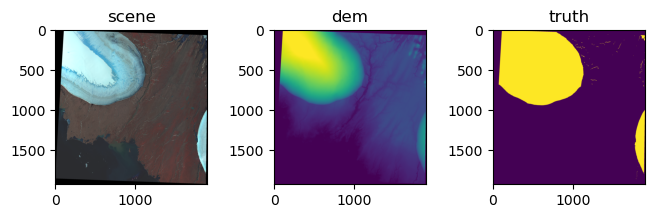

data/dset/scene/l8_scene_07.tif


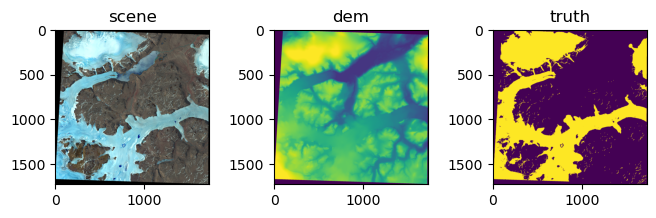

In [3]:
dset = list(zip(config.paths_scene, config.paths_truth, config.paths_dem))
for path_scene, path_truth, path_dem in dset[30:33]:
        print(path_scene)
        scene_rio = rio.open(path_scene)
        dem_rio = rio.open(path_dem)
        truth_rio = rio.open(path_truth)
        scene_truth_arr = [scene_rio.read([2,3,4]).transpose(1,2,0), 
                           dem_rio.read(1), truth_rio.read(1)]
        imsShow(img_list=scene_truth_arr,
                img_name_list=['scene', 'dem', 'truth'], figsize=(8,2))
        plt.show()


#### check the distribution of dataset

In [ ]:
print('Validation scene IDs:', config.ids_scene_val)
print('Training scene IDs:', config.ids_scene_tra) 


Validation scene IDs: ['l5_scene_01', 'l5_scene_05', 'l5_scene_09', 'l5_scene_13', 'l7_scene_04', 'l7_scene_08', 'l7_scene_12', 'l8_scene_03', 'l8_scene_07', 'l8_scene_11', 'l9_scene_02', 'l9_scene_06', 'l9_scene_10', 's2_scene_01', 's2_scene_05', 's2_scene_09', 's2_scene_13']
Training scene IDs: ['l5_scene_02', 'l5_scene_03', 'l5_scene_04', 'l5_scene_06', 'l5_scene_07', 'l5_scene_08', 'l5_scene_10', 'l5_scene_11', 'l5_scene_12', 'l7_scene_01', 'l7_scene_02', 'l7_scene_03', 'l7_scene_05', 'l7_scene_06', 'l7_scene_07', 'l7_scene_09', 'l7_scene_10', 'l7_scene_11', 'l7_scene_13', 'l8_scene_01', 'l8_scene_02', 'l8_scene_04', 'l8_scene_05', 'l8_scene_06', 'l8_scene_08', 'l8_scene_09', 'l8_scene_10', 'l8_scene_12', 'l8_scene_13', 'l9_scene_01', 'l9_scene_03', 'l9_scene_04', 'l9_scene_05', 'l9_scene_07', 'l9_scene_08', 'l9_scene_09', 'l9_scene_11', 'l9_scene_12', 'l9_scene_13', 's2_scene_02', 's2_scene_03', 's2_scene_04', 's2_scene_06', 's2_scene_07', 's2_scene_08', 's2_scene_10', 's2_scene_1

In [ ]:
path_truth_vec_tra = [config.dir_truth + scene_id + '.gpkg' for scene_id in config.ids_scene_tra]
path_truth_vec_val = [config.dir_truth + scene_id + '.gpkg' for scene_id in config.ids_scene_val]


In [ ]:
def get_center(path_vec):
  scene_id = path_vec.split('/')[-1].split('.')[0] 
  truth_vec_gpd = gpd.read_file(path_vec)
  truth_vec_gpd_wgs84 = truth_vec_gpd.to_crs(epsg=4326, inplace=False) 
  x_min, y_min, x_max, y_max = truth_vec_gpd_wgs84.union_all().bounds 
  center = ((x_min + x_max)/2, (y_min + y_max)/2) 
  return center, scene_id 
scene_centers, scene_ids = zip(*[get_center(path) for path in config.paths_truth_vec])


In [ ]:
from shapely.geometry import Point
dset_gdf = gpd.GeoDataFrame({
  'scene_id': [scene_id for scene_id in scene_ids],
  'satellite': [scene_id[0:2] for scene_id in scene_ids],
  'tra': [scene_id in config.ids_scene_tra for scene_id in scene_ids],
  'geometry': [Point(center) for center in scene_centers],
  }, 
  crs='EPSG:4326')
# dset_gdf.to_file('data/dset/dset.gpkg', driver='GPKG') 
dset_gdf.head()


,scene_id,satellite,tra,geometry
0,l5_scene_01,l5,False,POINT (-73.25983 -46.0353)
1,l5_scene_02,l5,True,POINT (-26.10997 80.77131)
2,l5_scene_03,l5,True,POINT (-26.55014 81.76744)
3,l5_scene_04,l5,True,POINT (-17.9464 64.27999)
4,l5_scene_05,l5,False,POINT (-81.60499 74.72179)


In [58]:
sat_colors = {'l5': 'red', 
              'l7': 'green', 
              'l8': 'blue', 
              'l9': 'orange', 
              's2': 'purple'}


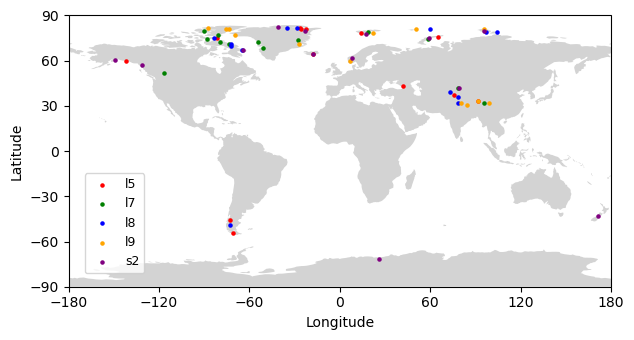

In [64]:
fig, ax = plt.subplots(figsize=(7, 5), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
for sat, color in sat_colors.items():
    dset_gdf[dset_gdf.scene_id.str[0:2] == sat].plot(
                    ax=ax, color=color, marker='o', markersize=5, label=sat)
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# # fig.savefig('figures/dset_distribution.png')



#### check the traset and valset

In [ ]:
dset_gdf[(dset_gdf.scene_id.str[0:2] == sat) & (~dset_gdf.tra)].plot(
                    ax=ax, color=color, marker='^', markersize=5)

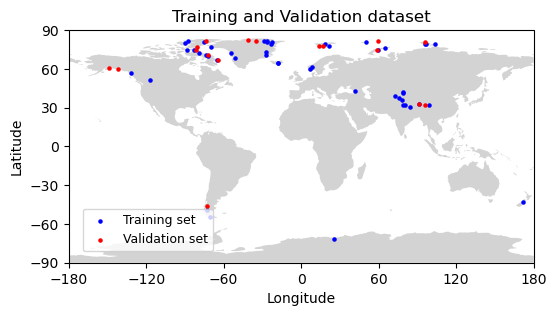

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), 
                subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
dset_gdf[dset_gdf.tra].plot(
                    ax=ax, 
                    color='blue', 
                    label='Training set',
                    markersize=5)
dset_gdf[~dset_gdf.tra].plot(
                    ax=ax, 
                    color='red', 
                    label='Validation set',
                    markersize=5)
ax.set_title('Training and Validation dataset')
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# fig.savefig('figs/traset_valset.png', dpi=300)

